## Project Week06

Yilun Wu (yw528)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from statsmodels.tsa.arima.model import ARIMA
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path: sys.path.append(module_path)
from lib.riskmgmt import return_calculate, compute_VaR, compute_ES
np.random.seed(545) # random seed for consistent result

### Problem 1

In [2]:
curr_date = pd.to_datetime('2023-03-03')
expiration_date = pd.to_datetime('2023-03-17')
time_to_maturity = (expiration_date-curr_date).days
print("Time to maturity: ", time_to_maturity, "days")

Time to maturity:  14 days


In [3]:
# Function for computing Black-Scholes prices (values)
def black_scholes(S, X, T, sigma, r, b, option_type):
    d1 = (np.log(S/X)+(b+sigma**2/2)*T)/(sigma*np.sqrt(T))
    d2 = d1-sigma*np.sqrt(T)
    if option_type == 'Call':
        return S*np.exp((b-r)*T)*norm.cdf(d1)-X*np.exp(-r*T)*norm.cdf(d2)
    elif option_type == 'Put':
        return X*np.exp(-r*T)*norm.cdf(-d2)-S*np.exp((b-r)*T)*norm.cdf(-d1)
    else:
        raise ValueError("Option type must be either 'Call' or 'Put'")

Assume we have At the Money (ATM) Option:

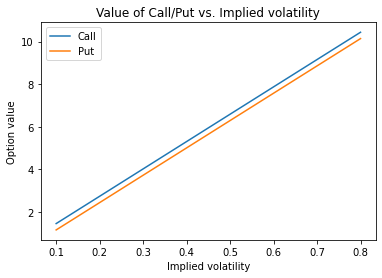

In [4]:
# Define all relevant factors
S = 165 # Underlying price
X = 165 # Strike price (== underlying price since ATM)
T = time_to_maturity/365 # Time to maturity in years
sigma = np.linspace(0.1, 0.8, 70) # Implied volatility
r = 0.0525 # Risk-free rate
q = 0.0053 # Continuous dividend rate
b = r-q # Cost of carry

# Compute and plot Black-Scholes prices for different implied volatilities
call_price = black_scholes(S, X, T, sigma, r, b, 'Call')
put_price = black_scholes(S, X, T, sigma, r, b, 'Put')
plt.plot(sigma, call_price, label='Call')
plt.plot(sigma, put_price, label='Put')
plt.xlabel('Implied volatility')
plt.ylabel('Option value')
plt.legend()
plt.title('Value of Call/Put vs. Implied volatility')
plt.show()

Assume In the Money for Call (and so Out of the Money for Put):

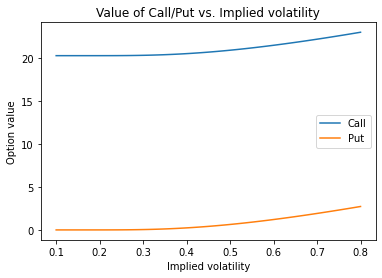

In [5]:
# Define all relevant factors
S = 165 # Underlying price
X = 145 # Strike price (< underlying price)
T = time_to_maturity/365 # Time to maturity in years
sigma = np.linspace(0.1, 0.8, 70) # Implied volatility
r = 0.0525 # Risk-free rate
q = 0.0053 # Continuous dividend rate
b = r-q # Cost of carry

# Compute and plot Black-Scholes prices for different implied volatilities
call_price = black_scholes(S, X, T, sigma, r, b, 'Call')
put_price = black_scholes(S, X, T, sigma, r, b, 'Put')
plt.plot(sigma, call_price, label='Call')
plt.plot(sigma, put_price, label='Put')
plt.xlabel('Implied volatility')
plt.ylabel('Option value')
plt.legend()
plt.title('Value of Call/Put vs. Implied volatility')
plt.show()

Assume In the Money for Put (and so Out of the Money for Call):

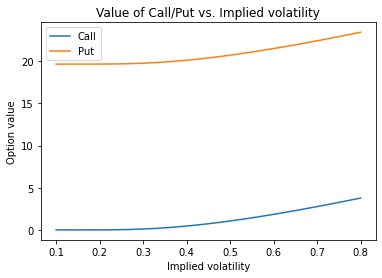

In [6]:
# Define all relevant factors
S = 165 # Underlying price
X = 185 # Strike price (> underlying price)
T = time_to_maturity/365 # Time to maturity in years
sigma = np.linspace(0.1, 0.8, 70) # Implied volatility
r = 0.0525 # Risk-free rate
q = 0.0053 # Continuous dividend rate
b = r-q # Cost of carry

# Compute and plot Black-Scholes prices for different implied volatilities
call_price = black_scholes(S, X, T, sigma, r, b, 'Call')
put_price = black_scholes(S, X, T, sigma, r, b, 'Put')
plt.plot(sigma, call_price, label='Call')
plt.plot(sigma, put_price, label='Put')
plt.xlabel('Implied volatility')
plt.ylabel('Option value')
plt.legend()
plt.title('Value of Call/Put vs. Implied volatility')
plt.show()

### Problem 2

In [7]:
# Read in AAPL Options data from csv file
AAPL_Options = pd.read_csv('AAPL_Options.csv')
AAPL_Options['Expiration'] = pd.to_datetime(AAPL_Options['Expiration'])
AAPL_Options

,Stock,Expiration,Type,Strike,Last Price
0,AAPL,2023-12-15,Call,140,30.95
1,AAPL,2023-12-15,Call,145,26.74
2,AAPL,2023-12-15,Call,150,22.80
3,AAPL,2023-12-15,Call,155,18.40
4,AAPL,2023-12-15,Call,160,14.15
5,AAPL,2023-12-15,Call,165,10.55
6,AAPL,2023-12-15,Call,170,7.21
7,AAPL,2023-12-15,Call,175,4.63
8,AAPL,2023-12-15,Call,180,2.67
9,AAPL,2023-12-15,Call,185,1.40


In [8]:
# Define all relevant factors
S = 170.15 # Underlying price (Current AAPL price)
curr_date = pd.to_datetime('2023-10-30') # Current date
r = 0.0525 # Risk-free rate
q = 0.0057 # Continuous dividend rate
b = r-q # Cost of carry

In [9]:
# Function for computing the implied volatility using gradient descent
def compute_implied_volatility(S, X, T, r, b, option_price, option_type):
    def error_function(sigma):
        return black_scholes(S, X, T, sigma, r, b, option_type)-option_price
    sigma = 0.5 # initial guess
    max_iter = 1000 # maximum number of iterations
    tol = 2e-3 # tolerance level
    for _ in range(max_iter):
        err = error_function(sigma)
        if abs(err) < tol: break # error is small enough
        err_derivative = (error_function(sigma+tol)-error_function(sigma))/tol # derivative of error w.r.t. sigma
        sigma -= err/err_derivative
    return sigma

In [10]:
# Calculate the implied volatility for each option
AAPL_Options['Implied Volatility'] = AAPL_Options.apply(lambda row: compute_implied_volatility(S, row['Strike'], (row['Expiration']-curr_date).days/365, r, b, row['Last Price'], row['Type']), axis=1)
AAPL_Options

,Stock,Expiration,Type,Strike,Last Price,Implied Volatility
0,AAPL,2023-12-15,Call,140,30.95,0.164603
1,AAPL,2023-12-15,Call,145,26.74,0.342745
2,AAPL,2023-12-15,Call,150,22.80,0.374271
3,AAPL,2023-12-15,Call,155,18.40,0.345738
4,AAPL,2023-12-15,Call,160,14.15,0.314150
5,AAPL,2023-12-15,Call,165,10.55,0.299386
6,AAPL,2023-12-15,Call,170,7.21,0.275944
7,AAPL,2023-12-15,Call,175,4.63,0.261184
8,AAPL,2023-12-15,Call,180,2.67,0.246307
9,AAPL,2023-12-15,Call,185,1.40,0.235333


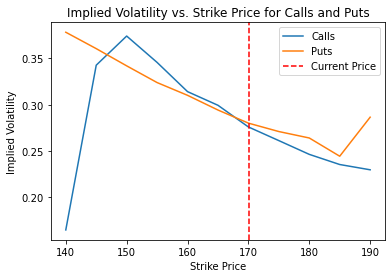

In [11]:
# Plot the implied volatility vs the strike price for Puts and Calls
calls = AAPL_Options[AAPL_Options['Type'] == 'Call']
puts = AAPL_Options[AAPL_Options['Type'] == 'Put']

plt.plot(calls['Strike'], calls['Implied Volatility'], label='Calls')
plt.plot(puts['Strike'], puts['Implied Volatility'], label='Puts')
plt.axvline(x=S, color='r', linestyle='--', label='Current Price')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.title('Implied Volatility vs. Strike Price for Calls and Puts')
plt.legend()
plt.show()

### Problem 3

##### Compute and graph portfolio value over a range of underlying values

In [12]:
# Read data from csv file
portfolio = pd.read_csv('problem3.csv')
portfolio['ExpirationDate'] = pd.to_datetime(portfolio['ExpirationDate'])
portfolio

,Portfolio,Type,Underlying,Holding,OptionType,ExpirationDate,Strike,CurrentPrice
0,Straddle,Option,AAPL,1,Call,2023-12-15,170.0,7.21
1,Straddle,Option,AAPL,1,Put,2023-12-15,170.0,6.16
2,SynLong,Option,AAPL,1,Call,2023-12-15,170.0,7.21
3,SynLong,Option,AAPL,-1,Put,2023-12-15,170.0,6.16
4,CallSpread,Option,AAPL,1,Call,2023-12-15,170.0,7.21
5,CallSpread,Option,AAPL,-1,Call,2023-12-15,180.0,2.67
6,PutSpread,Option,AAPL,1,Put,2023-12-15,170.0,6.16
7,PutSpread,Option,AAPL,-1,Put,2023-12-15,160.0,2.99
8,Stock,Stock,AAPL,1,NaN,NaT,NaN,170.15
9,Call,Option,AAPL,1,Call,2023-12-15,170.0,7.21


In [13]:
# Define all relevant factors
S0 = 170.15 # Underlying price (Current AAPL stock price)
curr_date = pd.to_datetime('2023-10-30') # Current date
r = 0.0525 # Risk-free rate
q = 0.0057 # Continuous dividend rate
b = r-q # Cost of carry

In [14]:
# Get names of all portfolios
portfolio_names = portfolio['Portfolio'].unique()
print("Number of portfolios: ", len(portfolio_names))
print("Portfolio names: ", portfolio_names)

Number of portfolios:  9
Portfolio names:  ['Straddle' 'SynLong' 'CallSpread' 'PutSpread' 'Stock' 'Call ' 'Put '
 'CoveredCall' 'ProtectedPut']


In [15]:
# Compute the portfolio value over a range of underlying values
def compute_portfolio_value(portfolios, S, S0, r, b, curr_date, num_days=0):
    portfolio_values = pd.DataFrame(index=portfolio_names, columns=[S])
    portfolio_values = portfolio_values.fillna(0)
    for _, portfolio in portfolios.iterrows():
        if portfolio['Type'] == 'Stock': # Stock
            current_price = S
        else: # Option
            # Compute the Implied Volatility
            T0 = (portfolio['ExpirationDate']-curr_date).days/365
            T = ((portfolio['ExpirationDate']-curr_date).days-num_days)/365
            K, price, option_type = portfolio['Strike'], portfolio['CurrentPrice'], portfolio['OptionType']
            sigma = compute_implied_volatility(S0, K, T0, r, b, price, option_type)
            # Compute the Black-Scholes price
            current_price = black_scholes(S, K, T, sigma, r, b, option_type)
        # Compute the portfolio value with payoff
        portfolio_values.loc[portfolio['Portfolio'], :] += portfolio['Holding']*current_price
    
    return portfolio_values

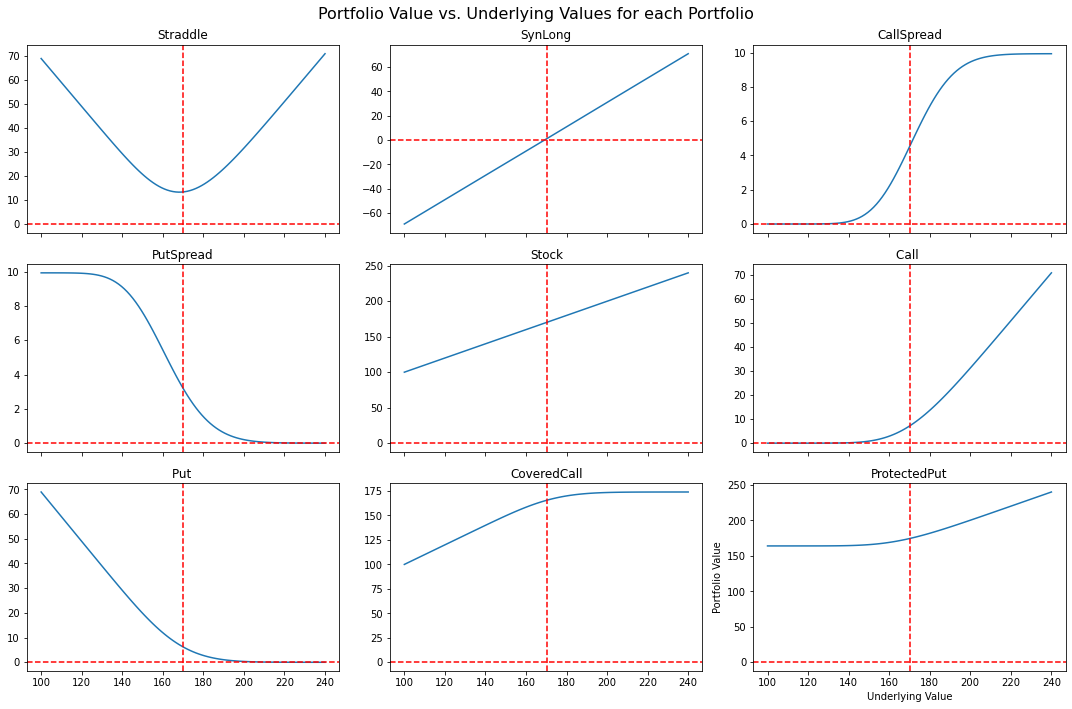

In [16]:
# Plot the portfolio value over a range of underlying values
S = np.linspace(100, 240, 100)
portfolio_values = compute_portfolio_value(portfolio, S, S0, r, b, curr_date)

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 10), sharex=True)
axs = axs.flatten()
for i in range(len(portfolio_names)):
    portfolio_name = portfolio_names[i]
    axs[i].plot(S, portfolio_values.loc[portfolio_name, :])
    axs[i].axvline(x=S0, color='r', linestyle='--')
    axs[i].axhline(y=0, color='r', linestyle='--')
    axs[i].set_title(portfolio_name)

plt.xlabel("Underlying Value")
plt.ylabel("Portfolio Value")
plt.suptitle("Portfolio Value vs. Underlying Values for each Portfolio", fontsize=16)
plt.tight_layout()
plt.show()

##### Compute the log returns of AAPL

In [17]:
# Read data from csv file
DailyPrices = pd.read_csv('DailyPrices.csv')
DailyPrices

,Date,SPY,AAPL,MSFT,AMZN,NVDA,GOOGL,TSLA,GOOG,BRK-B,...,CI,ETN,SLB,PGR,SCHW,LRCX,ZTS,C,BSX,AMT
0,2022-09-01,388.679565,157.028442,257.908386,127.820000,139.243423,109.739998,277.160004,110.550003,282.429993,...,282.124664,136.138718,36.036259,123.325203,70.653595,424.766022,158.011505,46.662727,40.990002,249.972107
1,2022-09-02,384.581177,154.891113,253.609909,127.510002,136.346054,107.849998,270.209991,108.680000,277.670013,...,281.791626,134.696564,37.229321,122.039116,69.294113,422.966797,155.602798,46.748875,40.490002,243.384186
2,2022-09-06,383.130066,153.618668,250.826813,126.110001,134.527710,106.809998,274.420013,107.480003,276.589996,...,280.483856,135.834595,36.703716,122.108894,69.422180,419.574921,155.464035,46.155418,40.380001,246.615067
3,2022-09-07,390.013000,155.040237,255.620483,129.479996,137.056152,109.449997,283.700012,110.480003,281.040009,...,285.154480,138.591293,36.408989,126.814598,70.722557,424.726715,158.992813,46.547867,41.470001,251.776749
4,2022-09-08,392.562256,153.549088,256.046387,129.820007,139.814484,108.379997,289.260010,109.419998,283.339996,...,285.852631,140.523956,37.499485,128.828476,72.072182,431.766174,157.099579,47.763493,42.709999,253.882172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,2023-09-18,443.630005,177.970001,329.059998,139.979996,439.660004,138.210007,265.279999,138.960007,370.429993,...,285.339996,219.149994,61.209999,140.559998,57.860001,635.650024,179.649994,42.639999,53.000000,179.529999
262,2023-09-19,442.709991,179.070007,328.649994,137.630005,435.200012,138.039993,266.500000,138.830002,370.480011,...,284.640015,216.160004,60.430000,142.470001,57.730000,625.150024,181.979996,42.680000,53.029999,177.360001
263,2023-09-20,438.640015,175.490005,320.769989,135.289993,422.390015,133.740005,262.589996,134.589996,366.820007,...,287.329987,214.649994,59.790001,142.690002,56.669998,618.859985,181.479996,42.299999,54.099998,177.410004
264,2023-09-21,431.390015,173.929993,319.529999,129.330002,410.170013,130.440002,255.699997,131.360001,363.279999,...,290.839996,210.649994,58.820000,142.399994,56.009998,610.390015,176.630005,41.709999,53.970001,169.320007


In [18]:
# Compute the log returns of AAPL and demean the series (so the mean is 0) 
AAPL_return = return_calculate(DailyPrices, method="LOG", dateColumn="Date")['AAPL']
AAPL_return -= AAPL_return.mean()
assert(AAPL_return.mean() < 1e-10) # mean should be 0
AAPL_return

/Users/wuyilun/Desktop/FINTECH545/lib/riskmgmt.py:236: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[vars[i]] = p2[:, i]
/Users/wuyilun/Desktop/FINTECH545/lib/riskmgmt.py:236: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[vars[i]] = p2[:, i]


0     -0.014109
1     -0.008653
2      0.008807
3     -0.010069
4      0.018260
         ...   
260    0.016368
261    0.005757
262   -0.020599
263   -0.009334
264    0.004528
Name: AAPL, Length: 265, dtype: float64

In [19]:
# Fit an AR(1) model to the log returns of AAPL
ar1 = ARIMA(AAPL_return, order=(1,0,0)).fit()
print(ar1.summary())

                               SARIMAX Results                                
Dep. Variable:                   AAPL   No. Observations:                  265
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 689.298
Date:                Fri, 03 Nov 2023   AIC                          -1372.597
Time:                        18:41:43   BIC                          -1361.858
Sample:                             0   HQIC                         -1368.282
                                - 265                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.012e-06      0.001     -0.002      0.999      -0.002       0.002
ar.L1         -0.0076      0.054     -0.140      0.888      -0.114       0.099
sigma2         0.0003   1.98e-05     16.272      0.0

In [20]:
# Simulate AAPL returns 10 days ahead and apply those returns to the current AAPL price
num_steps = 10
num_simulation = 1000
returns = AAPL_return.values
beta, alpha = ar1.params[0], ar1.params[1] 
sigma = np.sqrt(ar1.params[2])
returns_sim = np.zeros((num_steps, num_simulation))

for i in range(num_simulation): 
    returns_sim[0, i] = beta+alpha*returns[-1]+sigma*np.random.normal() 
    for j in range(1, num_steps):
        returns_sim[j, i] = beta+alpha*returns_sim[j-1, i]+sigma*np.random.normal()

prices_sim = S0*np.exp(returns_sim.cumsum(axis=0))
prices_sim = pd.DataFrame(prices_sim)
prices_sim

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,166.206409,169.823683,170.039134,176.965133,173.812091,170.136772,167.650234,175.864167,170.674044,173.524163,...,174.532189,172.533494,173.116635,165.453343,171.278751,164.681736,166.217380,171.798884,176.126116,173.479365
1,165.140786,171.467790,164.454727,177.888934,176.478401,177.468594,165.477665,178.639053,171.923570,172.422566,...,173.835364,173.974930,172.740109,165.112678,174.154896,164.801230,167.374147,173.515859,178.057769,168.597784
2,162.914151,170.099008,164.418019,177.398820,177.427556,177.341733,169.531222,176.256857,174.451896,172.490525,...,174.361845,171.258885,175.033744,163.730444,169.532051,164.303900,170.420456,172.761772,178.903314,168.660306
3,166.753721,168.365853,169.343117,179.568110,179.040207,178.241952,165.827033,174.603844,173.771448,173.340244,...,176.742272,169.645874,172.342362,161.195196,166.402228,168.774114,167.535632,172.433259,179.270994,170.295527
4,167.670316,170.553036,166.480251,175.827081,180.506717,173.323415,167.910392,178.292308,176.132390,170.924312,...,176.355318,171.043742,176.826270,157.521614,163.810988,173.086303,166.235494,171.162373,185.652580,173.578248
5,169.705051,173.115036,163.156984,174.851264,177.914988,176.084972,168.381082,175.975078,179.569383,167.110411,...,183.895945,164.662022,182.356335,158.749731,163.207181,170.868046,162.969519,173.874450,184.812330,172.574717
6,172.487952,176.716340,162.985998,174.795859,177.651384,172.955901,174.574223,175.769563,182.649740,167.647076,...,179.834259,162.726136,177.815192,157.440514,164.168642,167.529710,164.592161,173.699321,184.428152,174.434951
7,173.994184,178.744871,160.168788,174.059180,178.716266,169.750023,178.816538,175.533869,182.287472,166.448529,...,182.069163,165.540487,181.891501,155.694646,165.820581,167.584876,162.667809,176.665880,187.105260,174.188458
8,172.367520,177.553910,160.625325,175.102045,178.075870,163.525638,185.677495,173.226577,176.669727,166.471426,...,182.038945,171.304233,179.862810,152.979185,167.251866,166.375913,160.329635,178.026564,190.748862,178.483672
9,181.757579,180.534207,161.101841,174.056484,178.339024,161.349863,191.263979,176.781498,170.755213,165.171430,...,186.427089,173.259812,179.216465,153.993878,168.942470,163.652182,157.866236,179.606889,189.085311,176.846215


In [21]:
# Compute the current portfolio value and the simulated portfolio value 10 days ahead
prices_sim_curr = prices_sim.loc[num_steps-1:].values[0]
portfolio_values_sim = compute_portfolio_value(portfolio, prices_sim_curr, S0, r, b, curr_date, num_days=num_steps)
portfolio_values_curr = compute_portfolio_value(portfolio, S0, S0, r, b, curr_date, num_days=0)

# Then compute Mean, VaR and ES 
portfolio_values_both = pd.merge(portfolio_values_sim, portfolio_values_curr, left_index=True, right_index=True)
portfolio_values_changes = portfolio_values_both.sub(portfolio_values_both[S0], axis=0).drop(S0, axis=1)
portfolio_metrics = pd.DataFrame(index=portfolio_names, columns=['Mean', 'VaR', 'ES'])
portfolio_metrics = portfolio_metrics.fillna(0)
for portfolio_name in portfolio_names:
    portfolio_values = portfolio_values_changes.loc[portfolio_name, :]
    mean = portfolio_values.mean()
    VaR = compute_VaR(portfolio_values)
    ES = compute_ES(portfolio_values)
    portfolio_metrics.loc[portfolio_name, 'Mean'] = mean
    portfolio_metrics.loc[portfolio_name, 'VaR'] = VaR
    portfolio_metrics.loc[portfolio_name, 'ES'] = ES

portfolio_metrics

,Mean,VaR,ES
Straddle,0.894052,1.590079,1.598213
SynLong,0.015779,15.767682,19.974333
CallSpread,-0.112243,3.610685,3.983550
PutSpread,0.227656,2.485932,2.745747
Stock,0.206282,15.610066,19.833634
Call,0.454915,6.144357,6.588693
Put,0.439137,5.108837,5.517484
CoveredCall,-0.332388,11.411833,15.433885
ProtectedPut,0.534938,7.983553,8.810718
